# Importing Libraries

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
SMALL_SIZE = 18
MEDIUM_SIZE = 26
BIGGER_SIZE = 30
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
import copy
import random
from scipy.stats import t
fig_res = (24,16)
random.seed(42)


CI_SAMPLE_SIZE = 50
# Confidence Interval calculation
def confidence_interval(simulation_results, confidence=0.95, output_results=True):
    mean = np.mean(simulation_results)
    std = np.std(simulation_results)
    degree = len(simulation_results) - 1 
    t_crit = np.abs(t.ppf((1-confidence)/2, degree))    # Find the inverse cumulative distribution.
    ci = std*t_crit/np.sqrt(len(simulation_results))
    if output_results:
        print("Average waiting time is: ", mean)
        conf_int_low = mean-ci
        conf_int_high = mean+ci
        print("With the Confidence Interval: ", conf_int_low, conf_int_high)
        print("Confidence Interval Size: ", conf_int_high-conf_int_low)
        return
    else: return mean, ci

# Visualization of Average Results with CI from Simulations
def visualize_conf_interval(means, std, title, xlabel, ylabel, mc_chains=0, mc_chain_size=0):
    lower = np.subtract(means, std)
    upper = np.add(means, std)

    plt.figure(figsize=fig_res)
    plt.plot(means,'royalblue', label='Mean', linewidth=0.8)
    plt.plot(upper,'orange', label='Upper Boundary of CI', linewidth=0.3)
    plt.plot(lower,'darkorange', label='Lower Boundary of CI', linewidth=0.3)

    if (mc_chains!=0 or mc_chain_size!=0):
        temperature_changes = np.arange(0, mc_chains*mc_chain_size, mc_chain_size)
        for line in temperature_changes:
            plt.axvline(x=line, linewidth=0.1)

    plt.fill_between(list(range(len(means))), upper, lower, color="k", alpha=0.1)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()

    return

# Box plot for array of results from simulation
def box_plot(data, title, x_axis, x_axis_ticks, y_axis):
    fig, ax = plt.subplots(figsize = fig_res)
    ax.boxplot(data)
    ax.set_xticklabels(x_axis_ticks)
    fig.suptitle(title)
    plt.yscale('linear')
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.show()


# Class that represents a city (2D point)
class City:
    id: int
    x: float
    y: float

    def __init__(self, id, x, y):
        self.x = float(x)
        self.y = float(y)
        self.id = int(id)

# Reading File

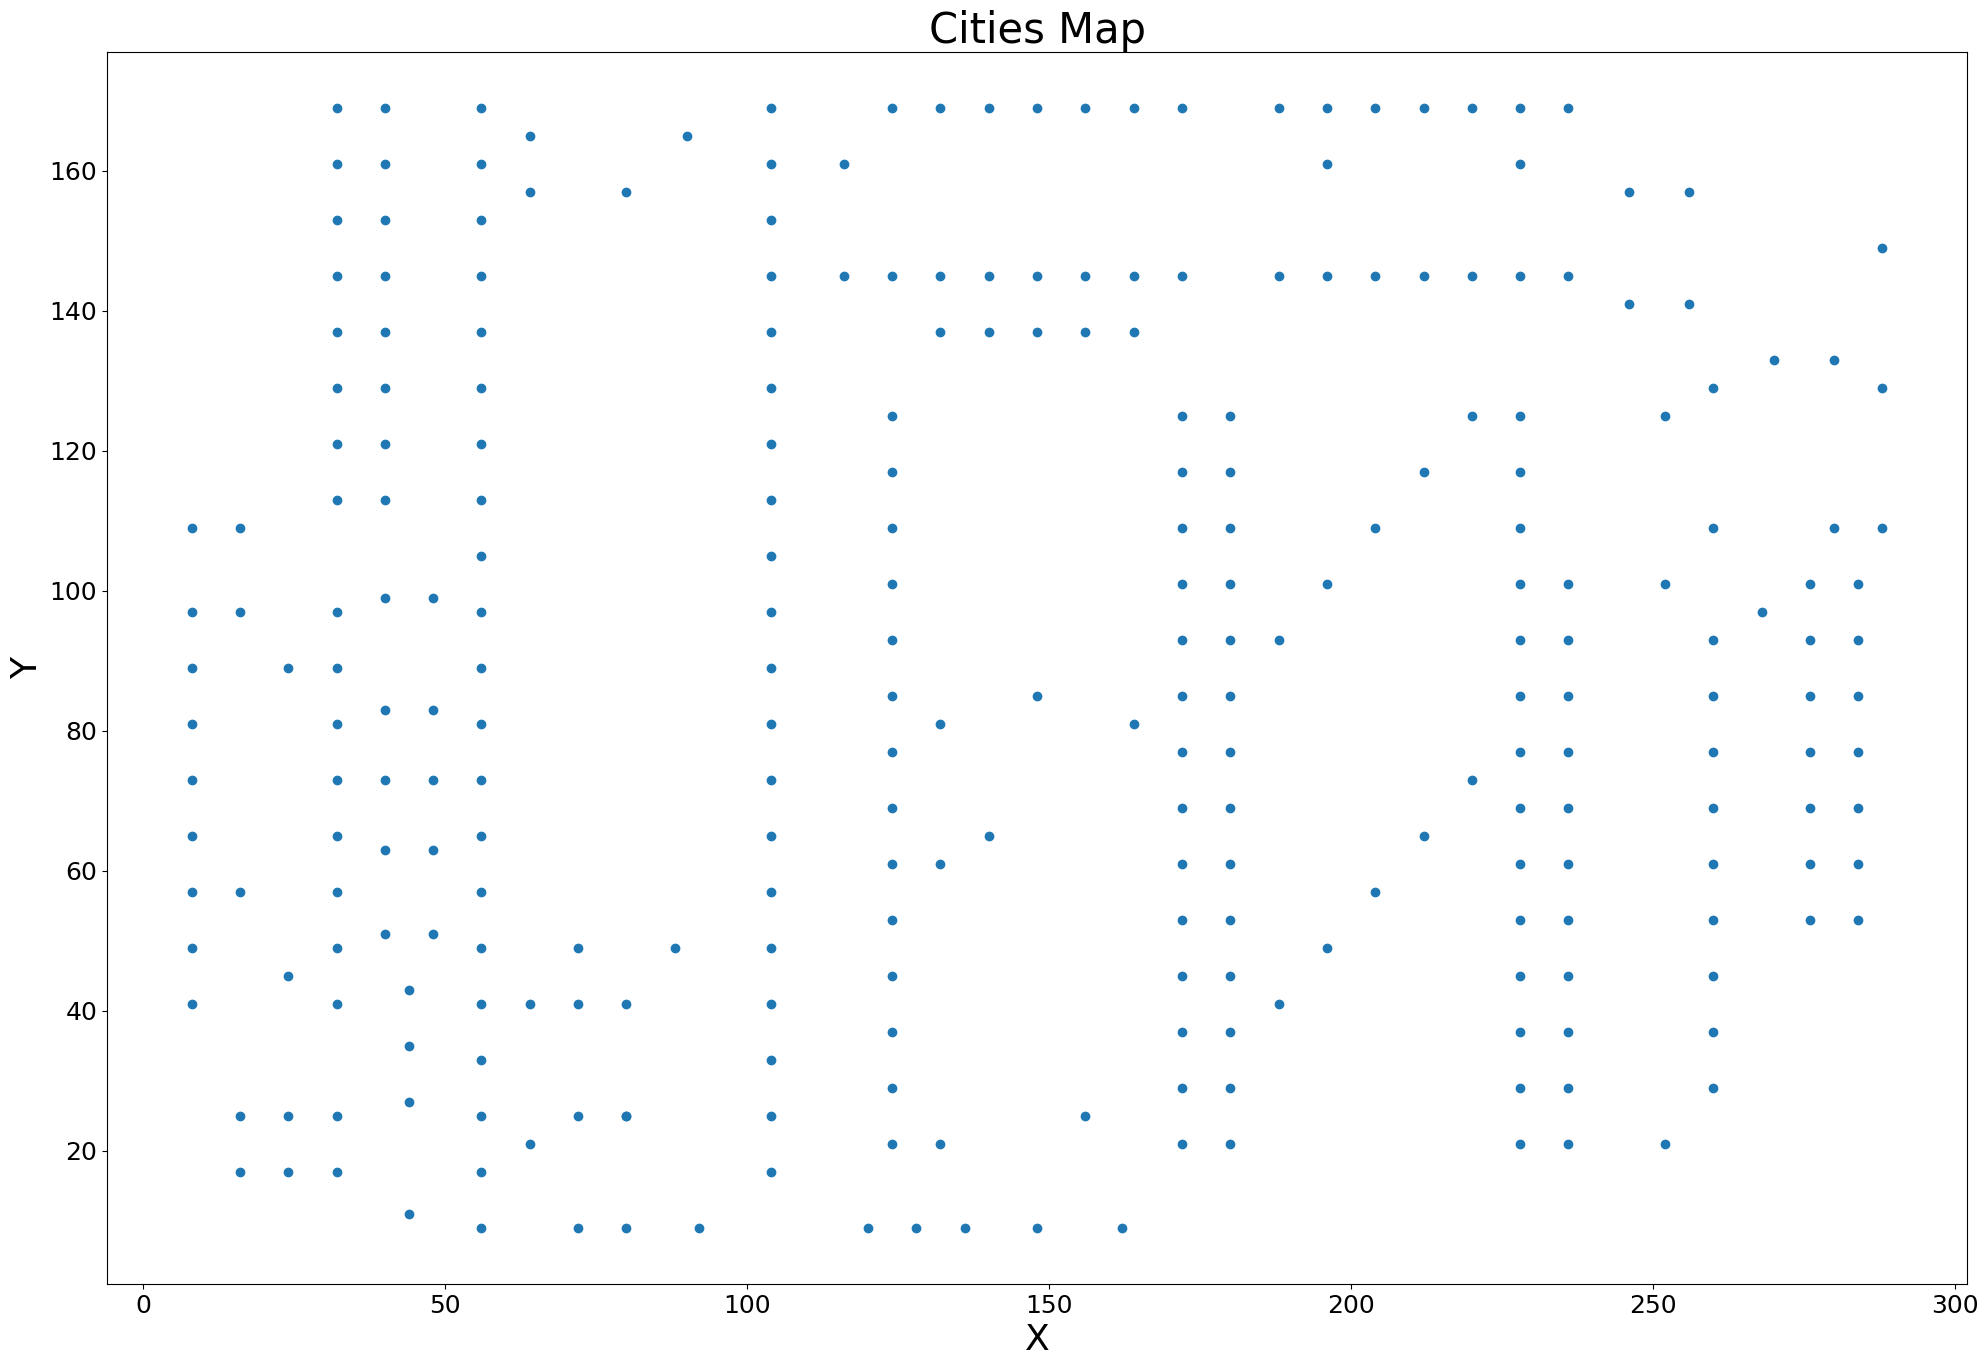

In [2]:
# Solving correct problem
problem_size = "medium"

if problem_size == "small":
    # File name of the problem
    file_name = "eil51.tsp.txt"
    # File Structure
    intro_lines = 6
    cities_amount = 51
elif problem_size == "medium":
    # File name of the problem
    file_name = "a280.tsp.txt"
    # File Structure
    intro_lines = 6
    cities_amount = 280
elif problem_size == "large":
    # File name of the problem
    file_name = "pcb442.tsp.txt"
    # File Structure
    intro_lines = 6
    cities_amount = 442


cities = []
with open(file_name,"r") as f:
    for i in range(intro_lines):
        f.readline()
    for i in range(cities_amount):
        line = f.readline()
        id, x, y = line.split()
        cities.append(City(id, x, y))

coordinates_x = []
coordinates_y = []
for City in cities:
    coordinates_x.append(City.x)
    coordinates_y.append(City.y)
plt.figure(figsize=fig_res)
plt.title("Cities Map")
plt.xlabel("X")
plt.ylabel("Y")
plt.scatter(coordinates_x, coordinates_y)

# Solving Traveling Salesman Problem

Init Path
Random path's distance:  34441.15927408143


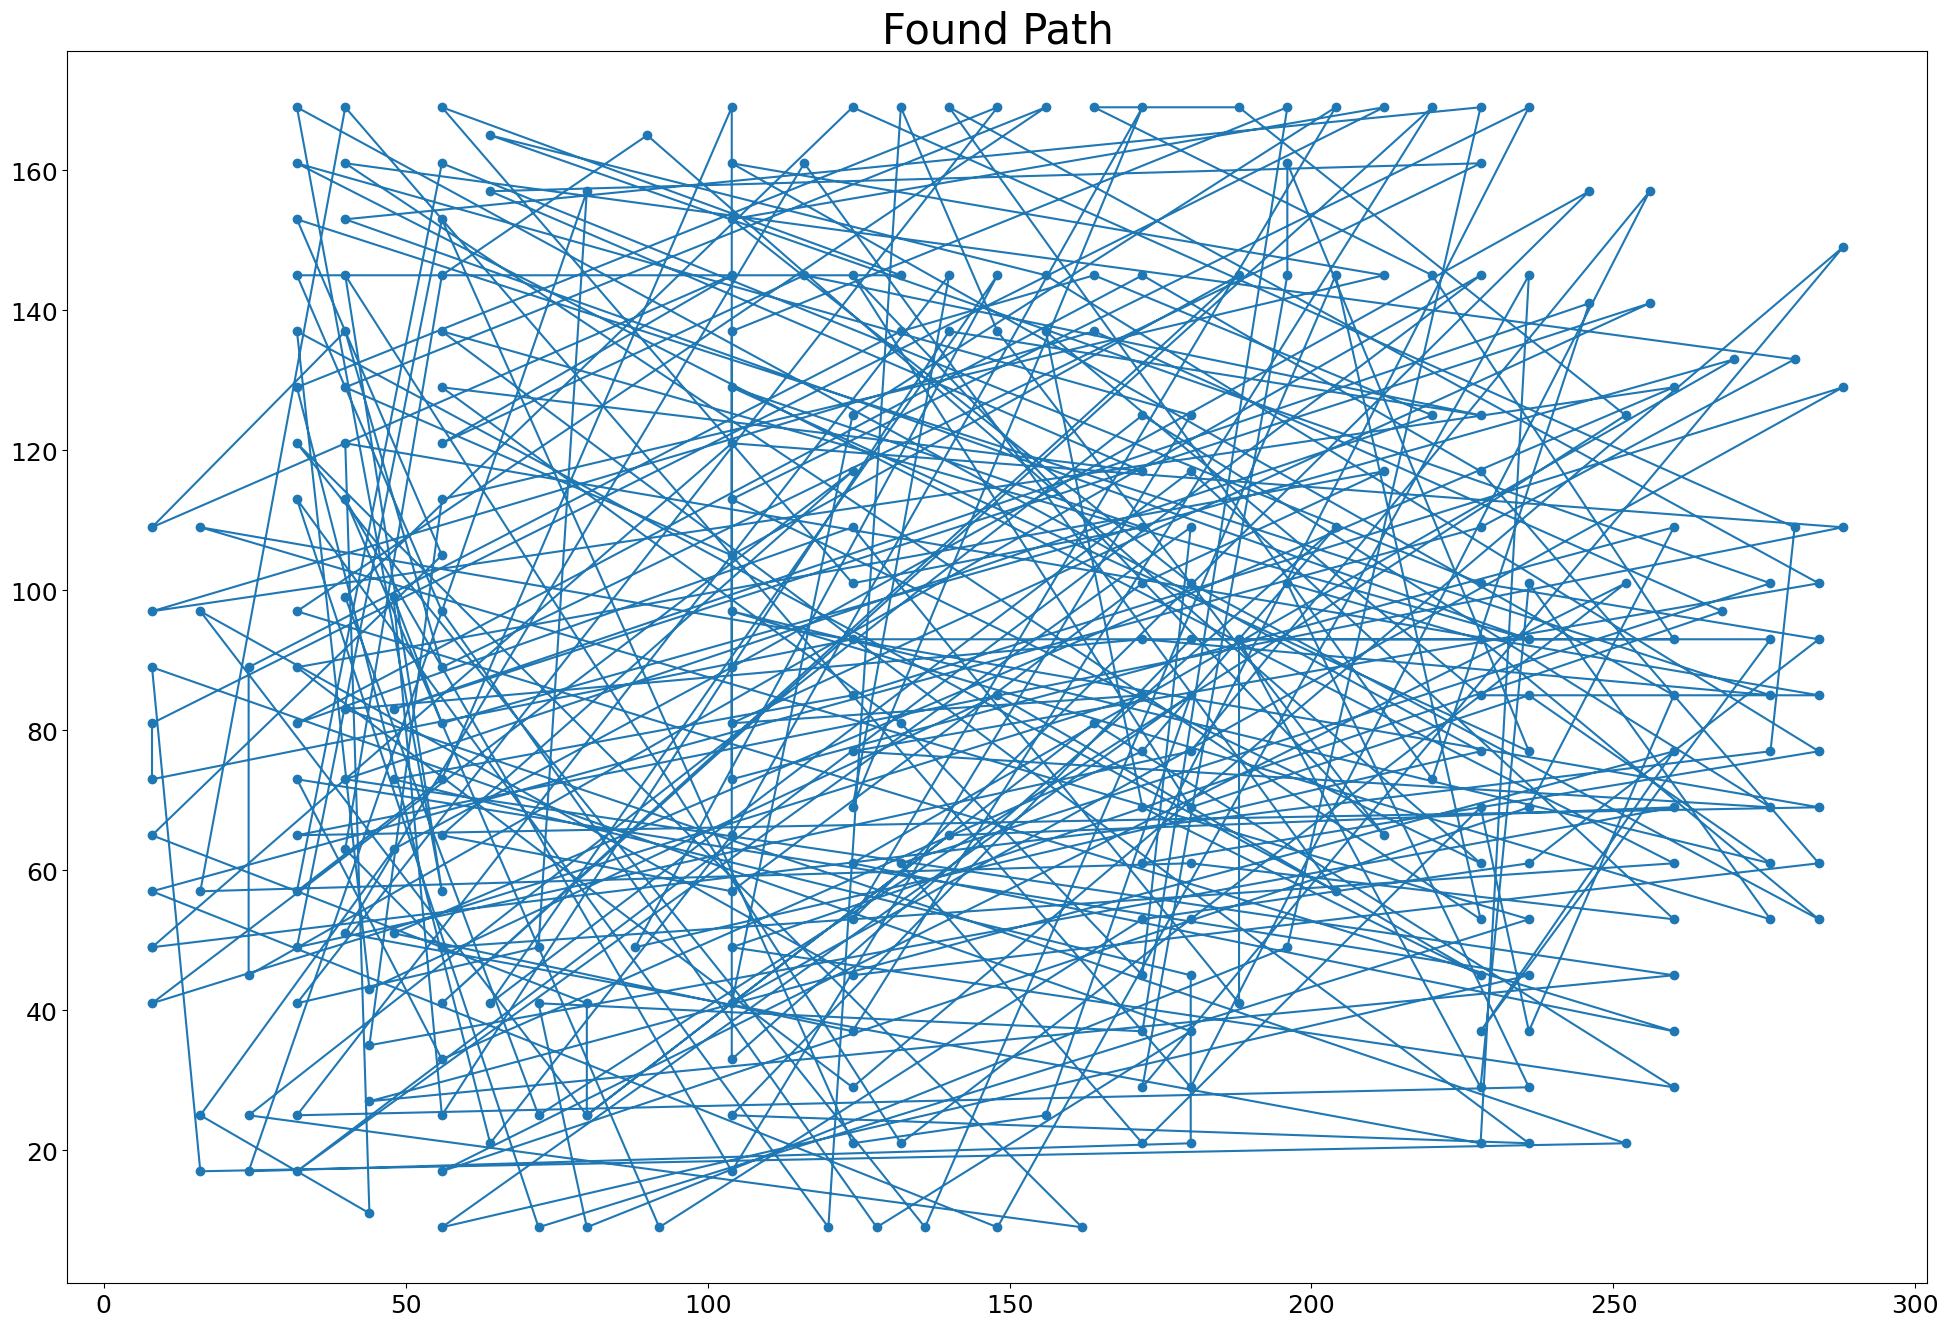

In [7]:
# Creating class for a path
class Path:
    city_ids = []

    def __init__(self, city_ids = []):
        self.city_ids = copy.deepcopy(city_ids)

    # Finds overall size of the path with Euclidean Distance (Fitness Function)
    def eval_distance(self):
        distance = 0
        for i in range(len(self.city_ids)-1):            
            # Because cities ids are starting from 1, and array starts at 0
            distance += np.sqrt(
            (cities[self.city_ids[i+1]-1].x - cities[self.city_ids[i]-1].x)**2 + 
            (cities[self.city_ids[i+1]-1].y - cities[self.city_ids[i]-1].y)**2 )
        return distance

    # Path is invalid if returned to non starting location at the end
    def eval_validity(self):
        if self.city_ids[0] == self.city_ids[-1]:
            return True
        else: return False

    # Visualize Path
    def visualize(self):
        coordinates_x = []
        coordinates_y = []
        for i in self.city_ids:
            coordinates_x.append(cities[i-1].x)       # Because cities ids are starting from 1, and array starts at 0
            coordinates_y.append(cities[i-1].y)
        plt.figure(figsize=fig_res)
        plt.scatter(coordinates_x, coordinates_y)
        plt.title("Found Path")
        plt.plot(coordinates_x, coordinates_y)
        plt.show()
    # Print Path
    def visualize_print(self):
        print(self.city_ids)

    # Generating new paths
    # Random Permutations, k=amount of swaps
    def generate_new_path_random_swapping(self, k):
        city_ids_new = copy.deepcopy(self.city_ids)

        ids_to_swap = np.random.randint(1, len(self.city_ids)-1, k*2)   # We are not swapping start and end
        ids_to_swap.sort()

        for j in range(0, k, 2):
            city_ids_new[ids_to_swap[j]], city_ids_new[ids_to_swap[j+1]] = city_ids_new[ids_to_swap[j+1]], city_ids_new[ids_to_swap[j]]
        return Path(city_ids_new)
    # Inserting of vertices, k=amount of inserts
    # Take a vertex, place it in a location, shift other
    def generate_new_path_insertting(self, k):
        city_ids_new = copy.deepcopy(self.city_ids)

        ids_to_swap = np.random.randint(1, len(self.city_ids)-1, k*2)   # We are not swapping start and end
        ids_to_swap.sort()

        for j in range(0, k, 2):
            # Saving Value
            insert_value = city_ids_new[ids_to_swap[j+1]]
            # Shifting
            city_ids_new[ids_to_swap[j]+1:ids_to_swap[j+1]+1] = city_ids_new[ids_to_swap[j]:ids_to_swap[j+1]] 
            # Inserting
            city_ids_new[ids_to_swap[j]] = insert_value
        return Path(city_ids_new)
    # k-Opt
    def generate_new_path_k_opt(self, k):
        city_ids_new = copy.deepcopy(self.city_ids)

        ids_to_swap = np.random.randint(1, len(self.city_ids)-1, k)   # We are not swapping start and end, they will be swapped if we change id: 1 and N-1
        while len(np.unique(ids_to_swap)) != len(ids_to_swap):
            ids_to_swap = np.random.randint(1, len(self.city_ids)-1, k)
        ids_to_swap.sort()

        for j in range(k-1):
            city_ids_new[ids_to_swap[j]:ids_to_swap[j+1]] = reversed(city_ids_new[ids_to_swap[j]:ids_to_swap[j+1]])
        return Path(city_ids_new)

def generate_initial_random_path(cities):
    # Generating some initial guess for the Path (Simplest way to create initial guess is just to shuffle)
    shuffled = sorted(cities, key=lambda k: random.random())
    shuffled.append(shuffled[0])    # So that path is cycle
    city_ids_init_path = []
    for city in shuffled:
        city_ids_init_path.append(city.id)
    initial_path = Path(city_ids_init_path)
    return initial_path

initial_path = generate_initial_random_path(cities)
print("Init Path")
print("Random path's distance: ", initial_path.eval_distance())     # Evaluate circuit size
initial_path.visualize()                # And see it

# Greedy Solution

In [4]:
# Iterative Method (Greedy) to find the solution
def greedy_solution(search_method, k, path, step_max, visualize_results):
    
    solutions_history = []

    # Random Permutations to find the better path
    for i in range(step_max):
        if search_method == "random":
            new_path = path.generate_new_path_random_swapping(k) # k = Amount of swaps
        if search_method == "insert":
            new_path = path.generate_new_path_insertting(k)      # k = Amount of inserts
        if search_method == "k-opt":
            new_path = path.generate_new_path_k_opt(k)           # k = amount of rewires

        solutions_history.append(new_path.eval_distance())

        if new_path.eval_distance() < path.eval_distance():
            path = new_path

    if visualize_results:
        print("Gready Path")
        print(path.eval_validity())     # If everything is ok it should be True
        print("Best path's distance: ", path.eval_distance())     # Evaluate circuit size
        path.visualize()                # And see it
    return path, solutions_history

Generating Visualization of Paths: 100%|██████████| 10000/10000 [00:01<00:00, 9003.54it/s]


Typical Gready Solution with  10000  Amount of Steps
Best found paths lengths:  (6896.9109999326465, 63.87162411069114)



Generating Visualization of Paths: 100%|██████████| 25000/25000 [00:02<00:00, 9564.05it/s]


Typical Gready Solution with  25000  Amount of Steps
Best found paths lengths:  (4799.907331658075, 38.16943670513691)



Generating Visualization of Paths: 100%|██████████| 100000/100000 [00:10<00:00, 9179.50it/s]


Typical Gready Solution with  100000  Amount of Steps
Best found paths lengths:  (3327.75516544498, 27.98093525957667)



Generating Visualization of Paths: 100%|██████████| 250000/250000 [00:26<00:00, 9430.00it/s]


Typical Gready Solution with  250000  Amount of Steps
Best found paths lengths:  (3097.604486731095, 23.750904119864778)



Generating Visualization of Paths: 100%|██████████| 1000000/1000000 [01:47<00:00, 9317.68it/s]


Typical Gready Solution with  1000000  Amount of Steps
Best found paths lengths:  (3099.9900434717456, 25.530524524703036)



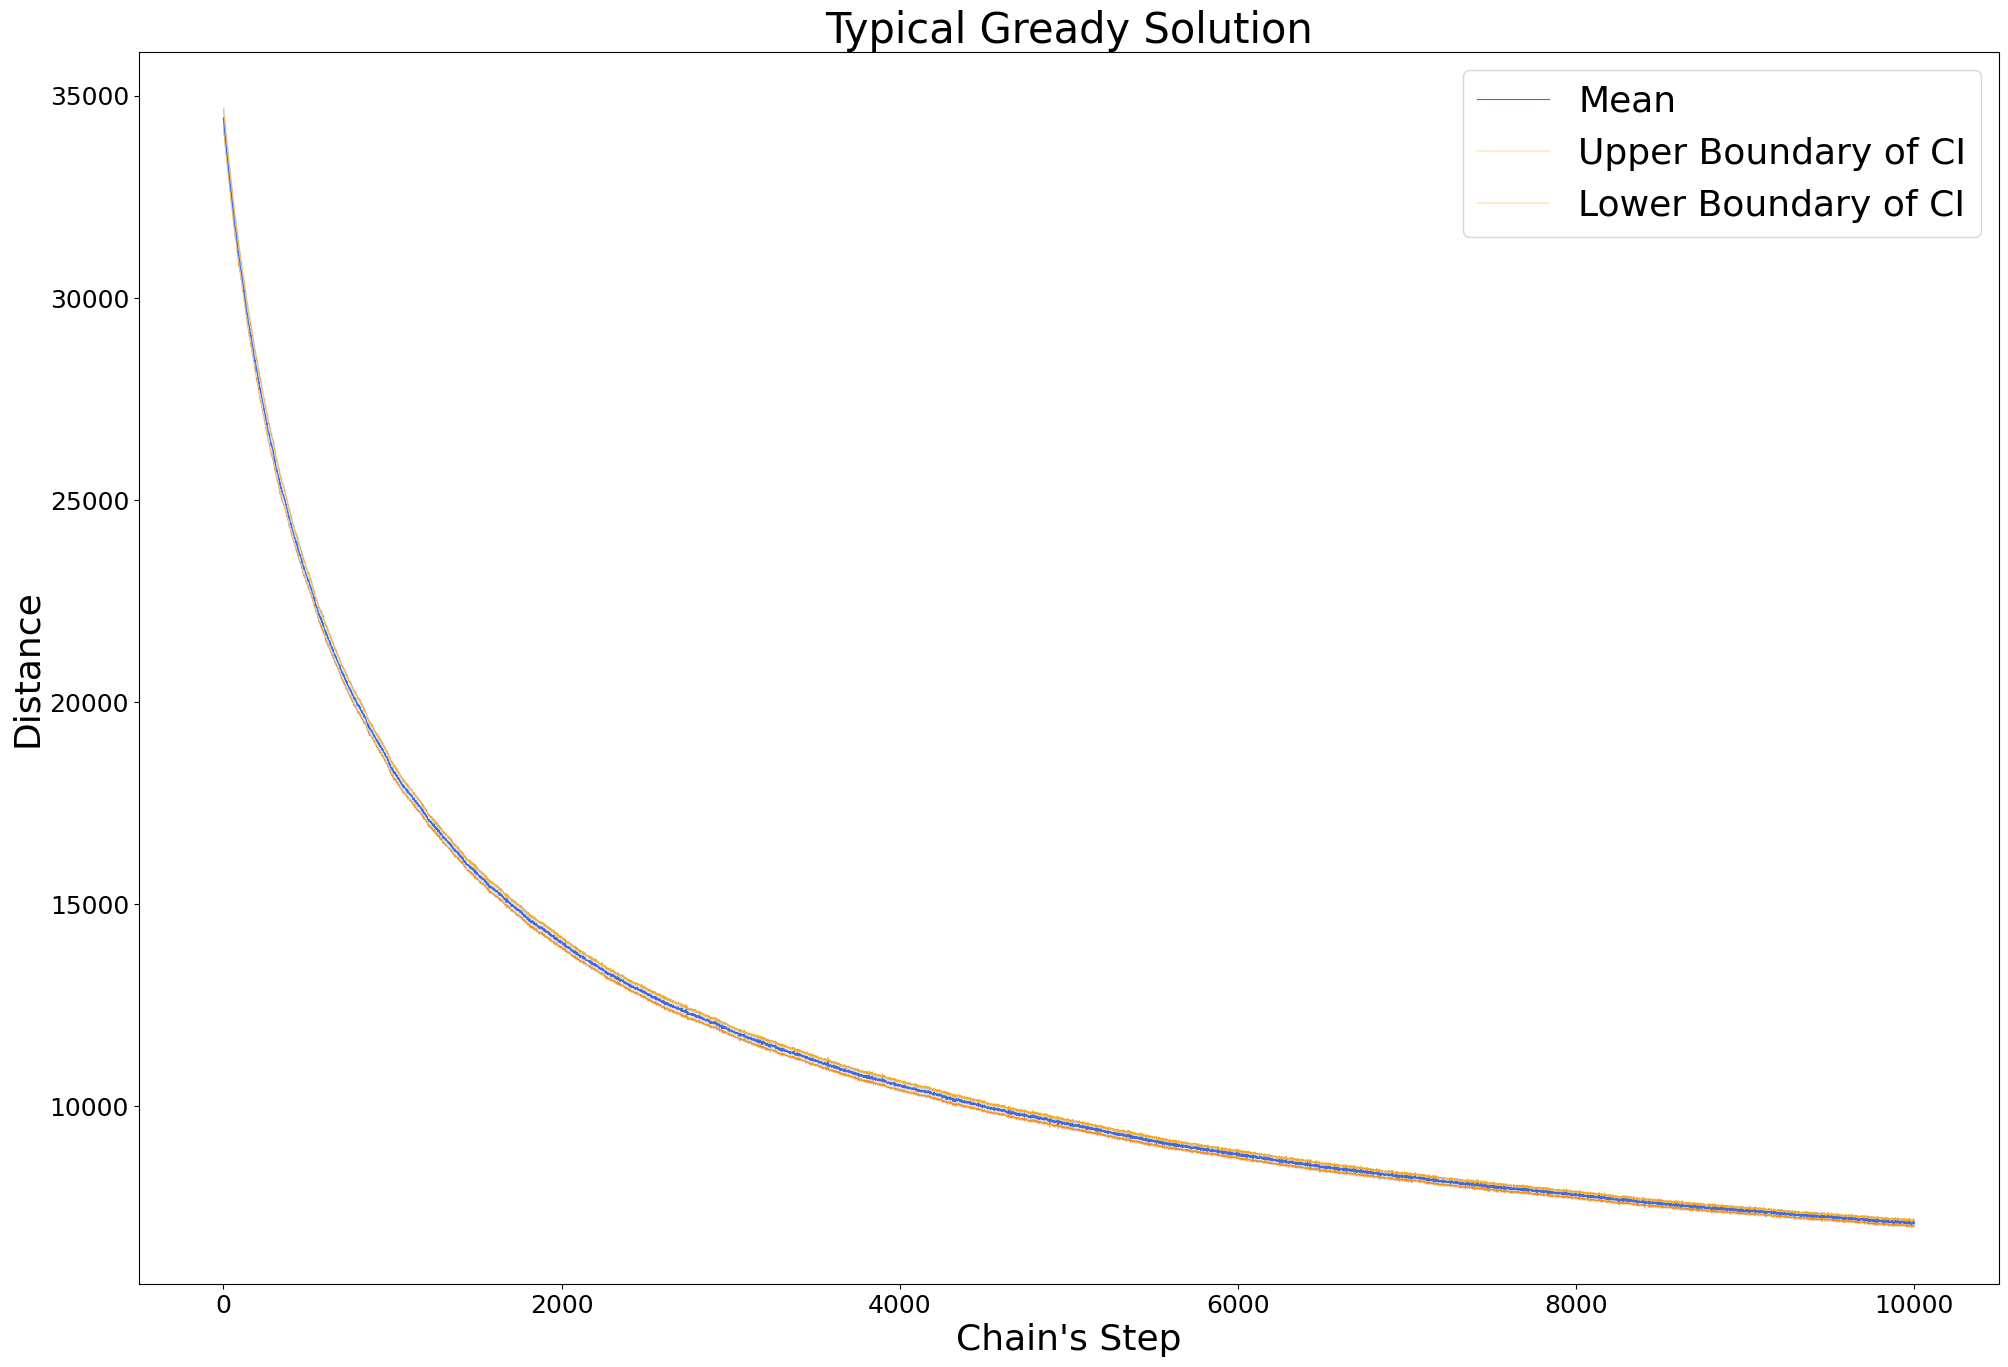

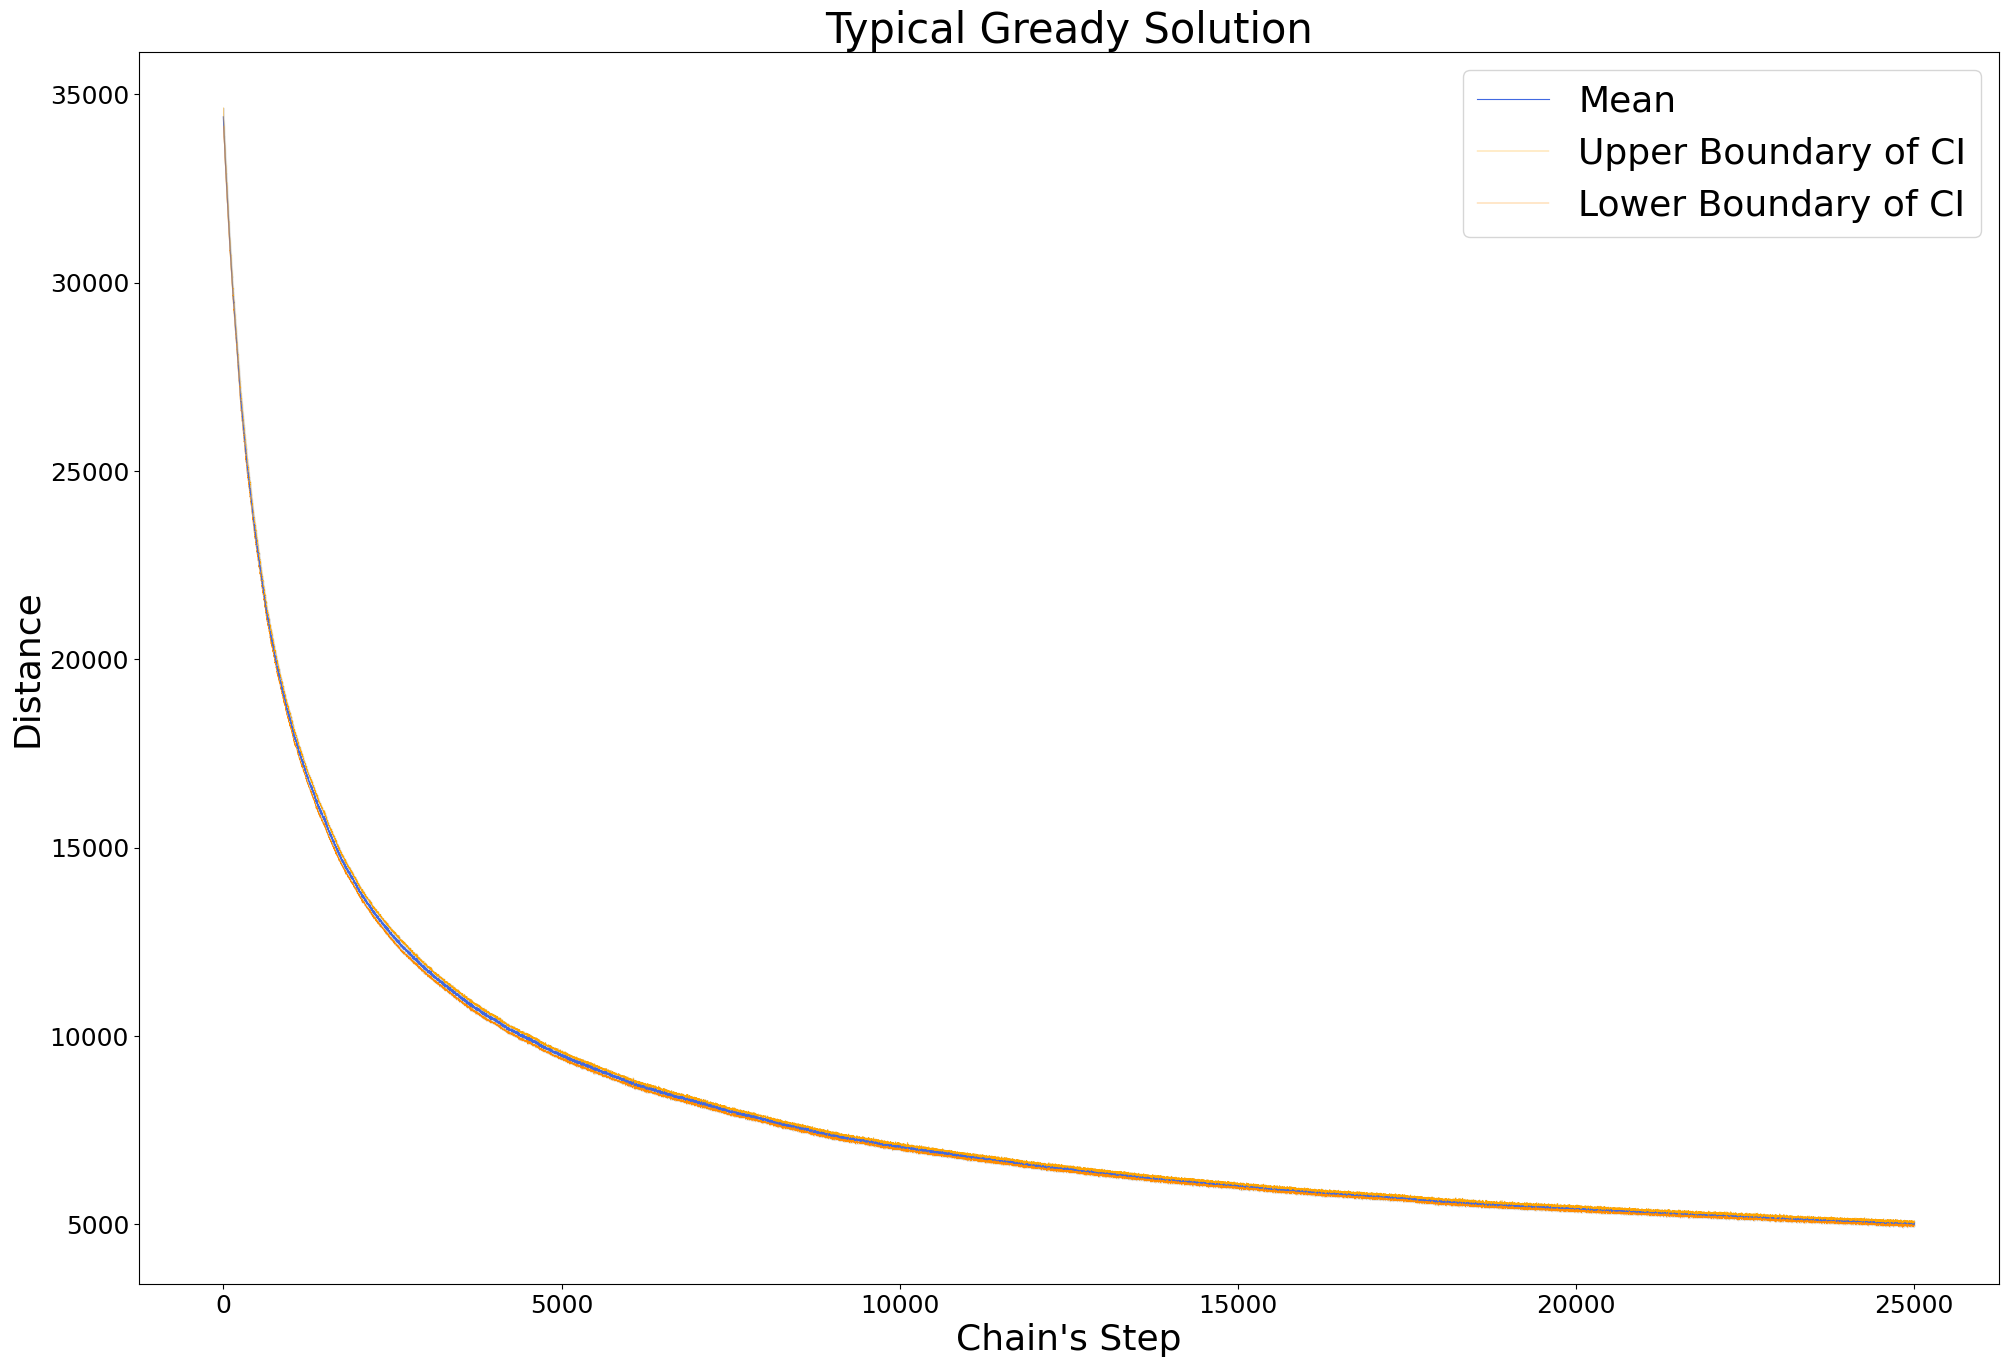

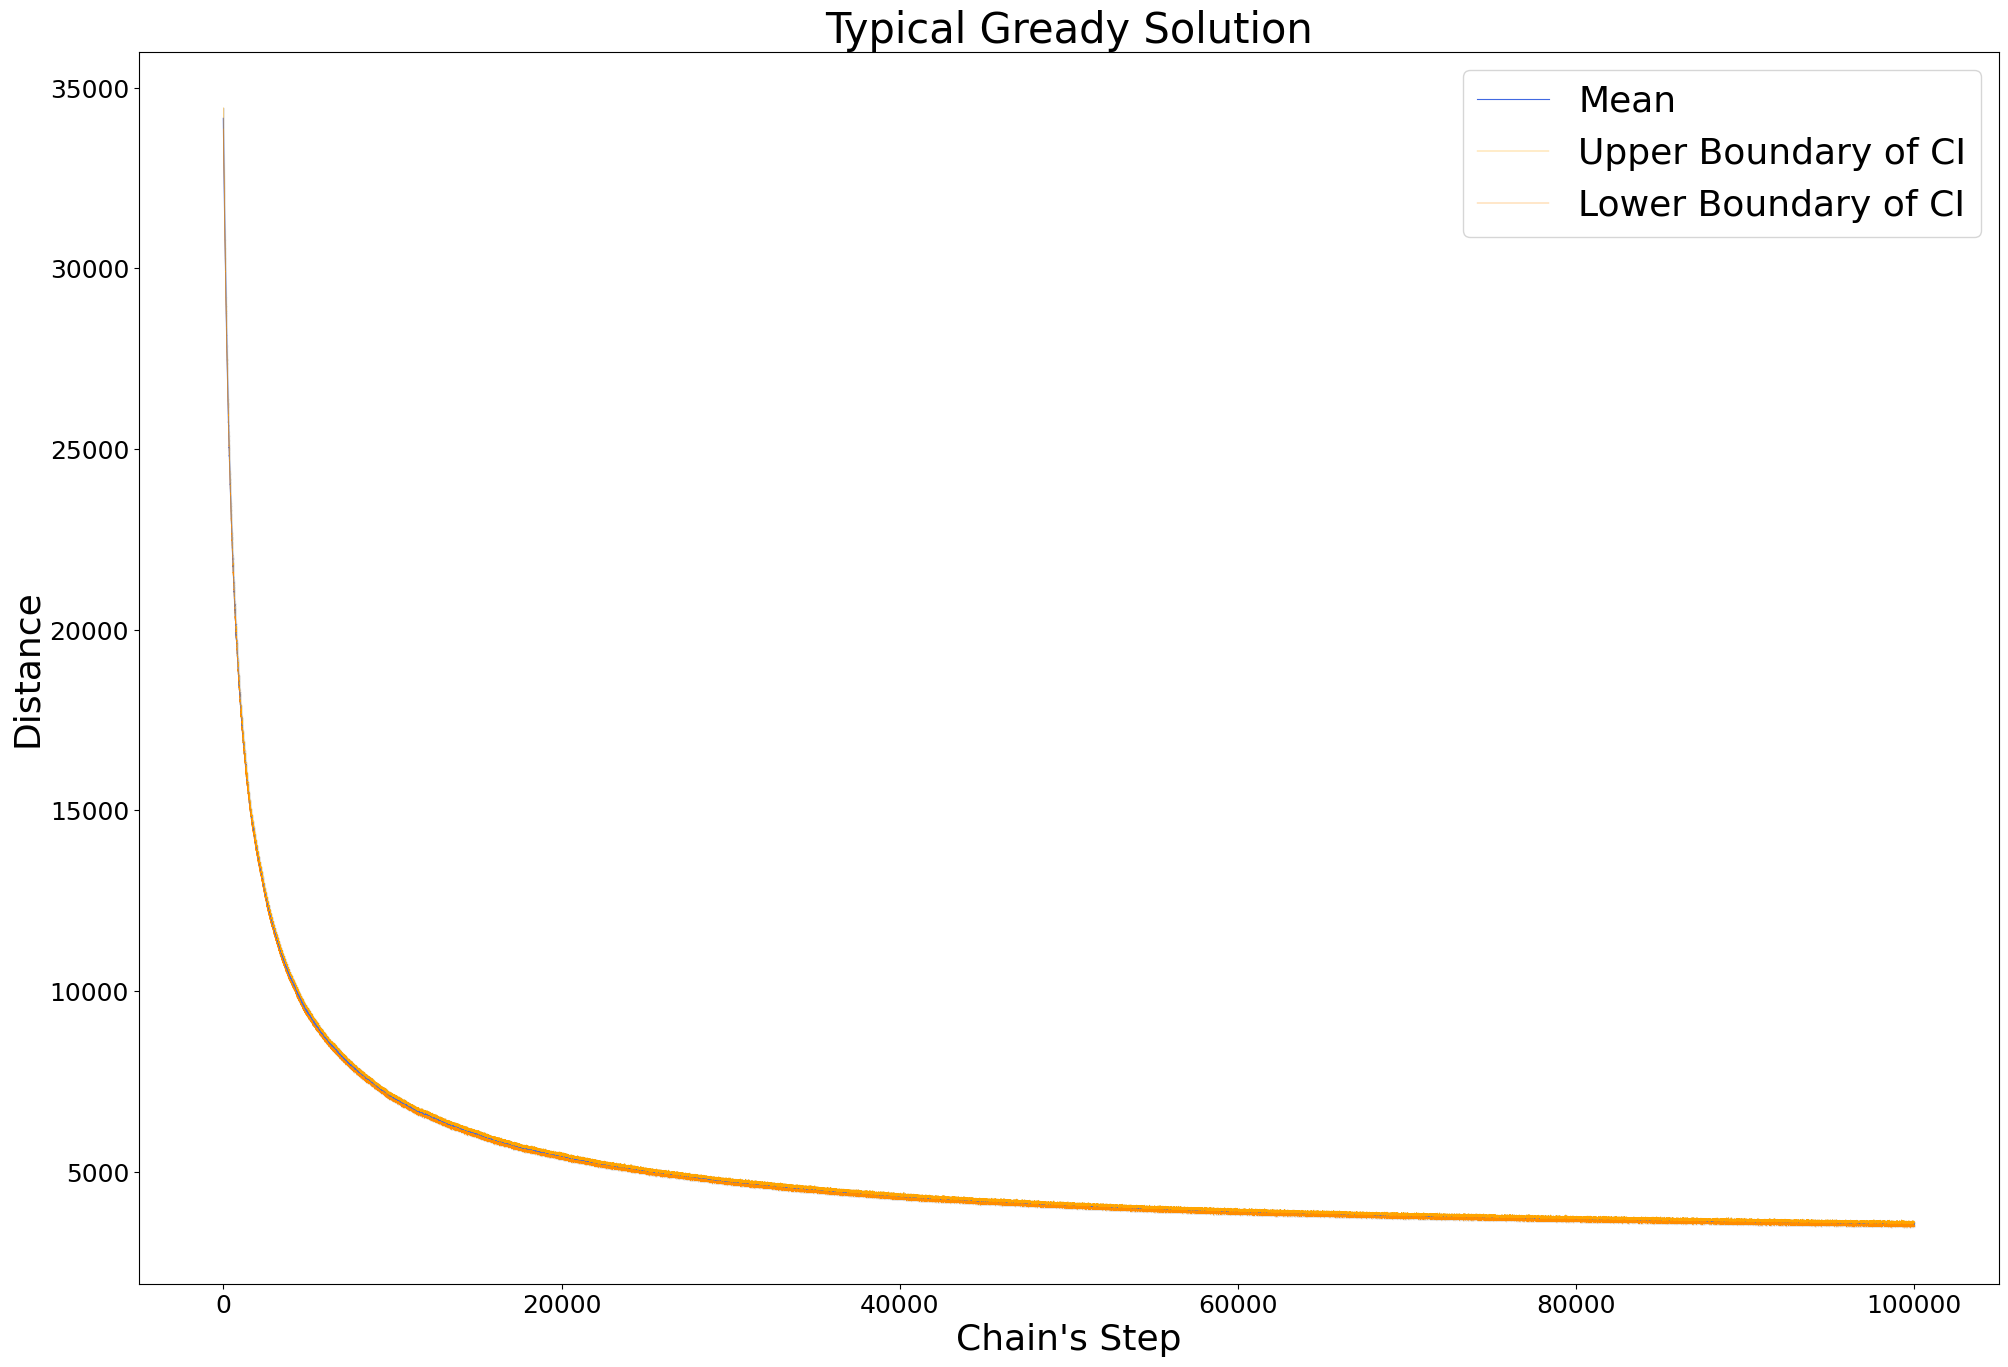

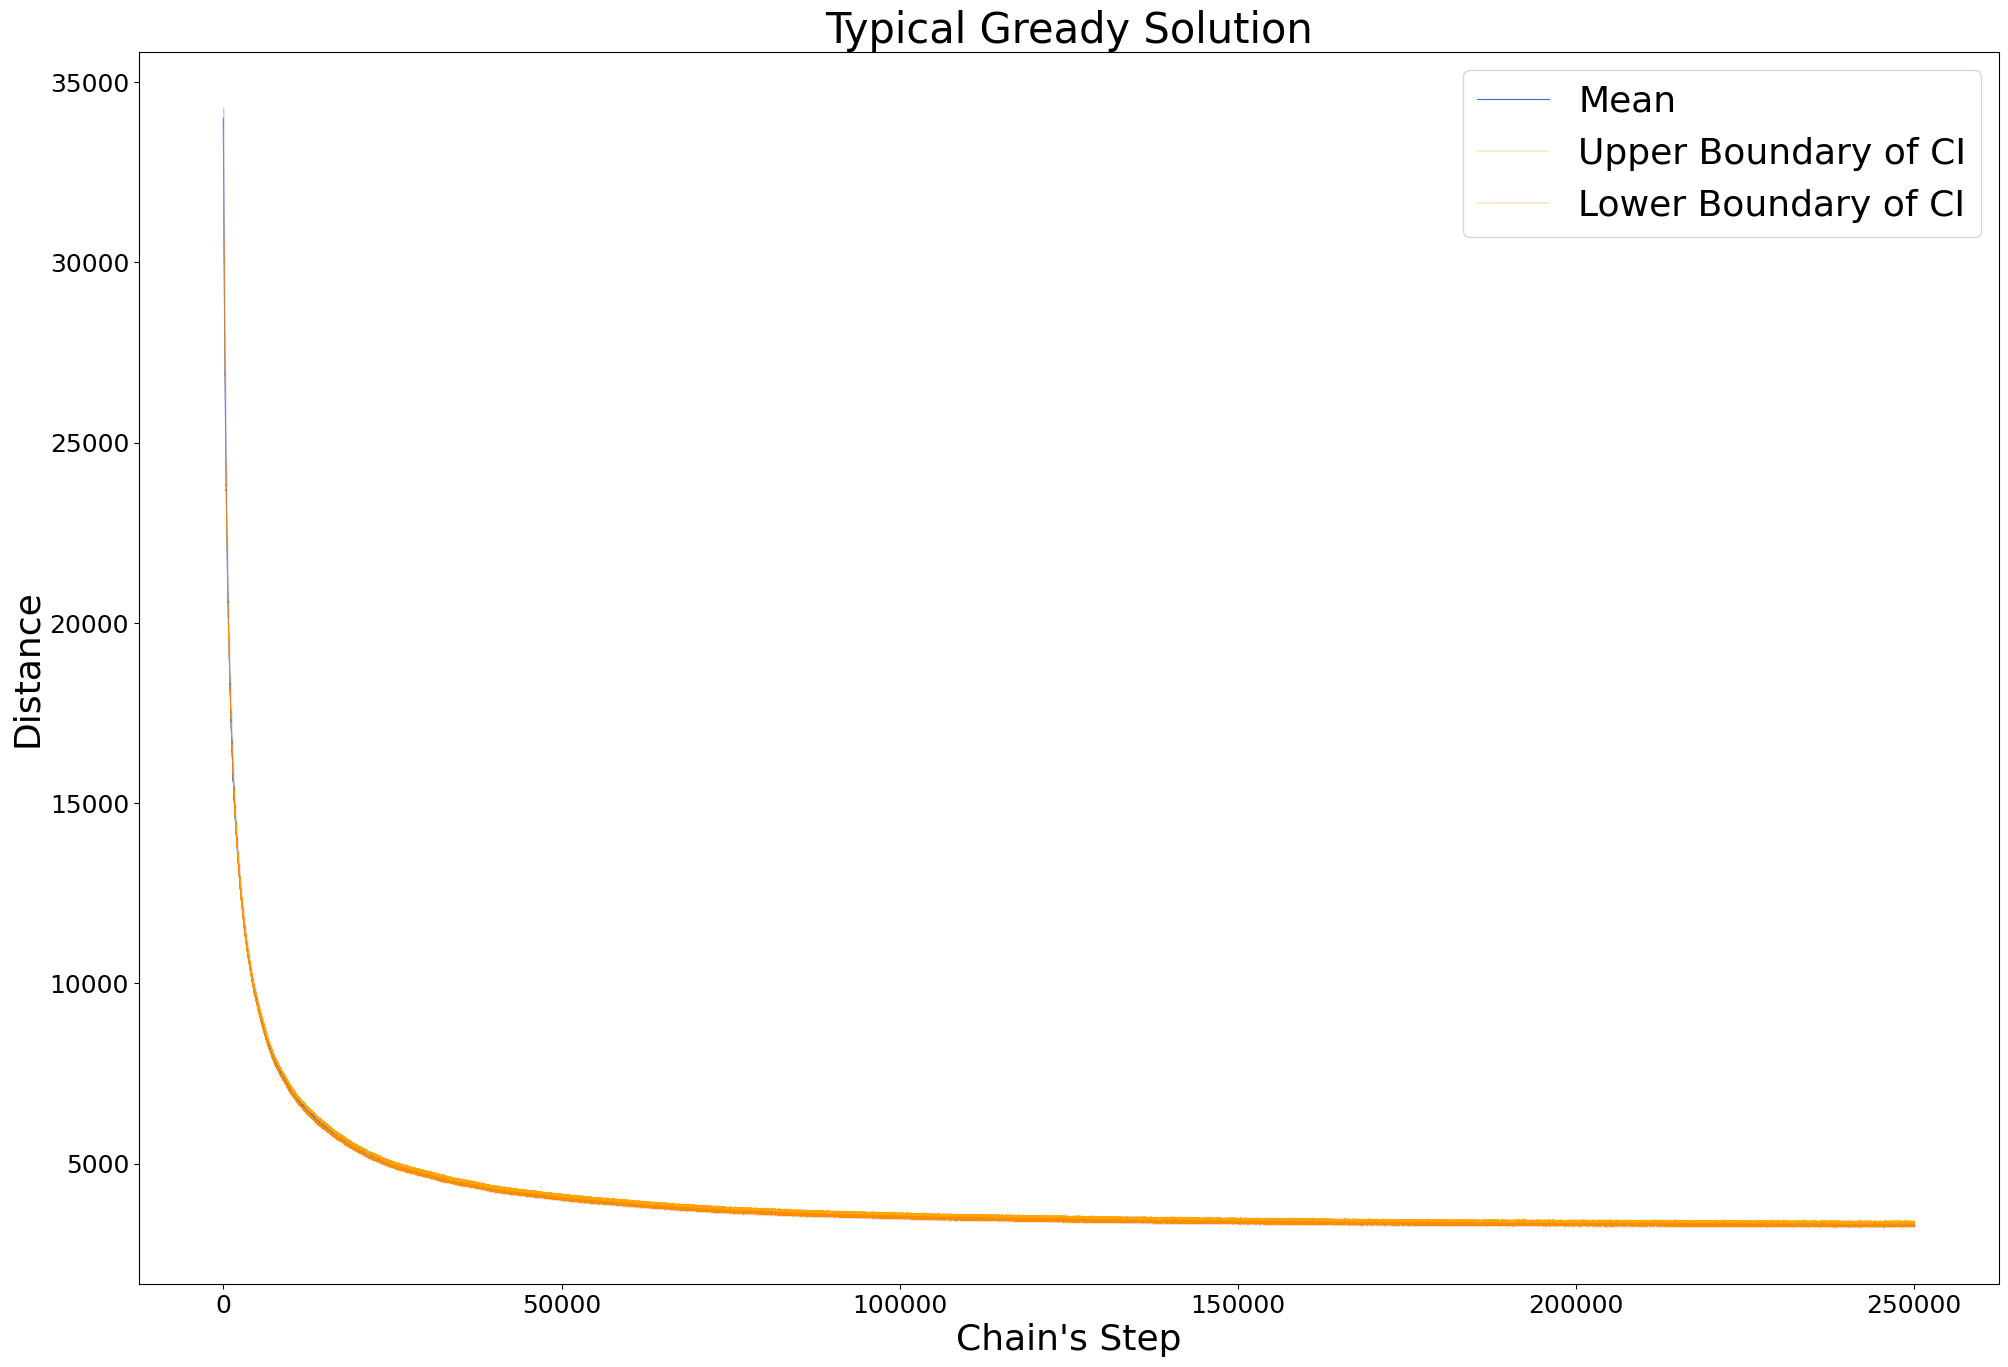

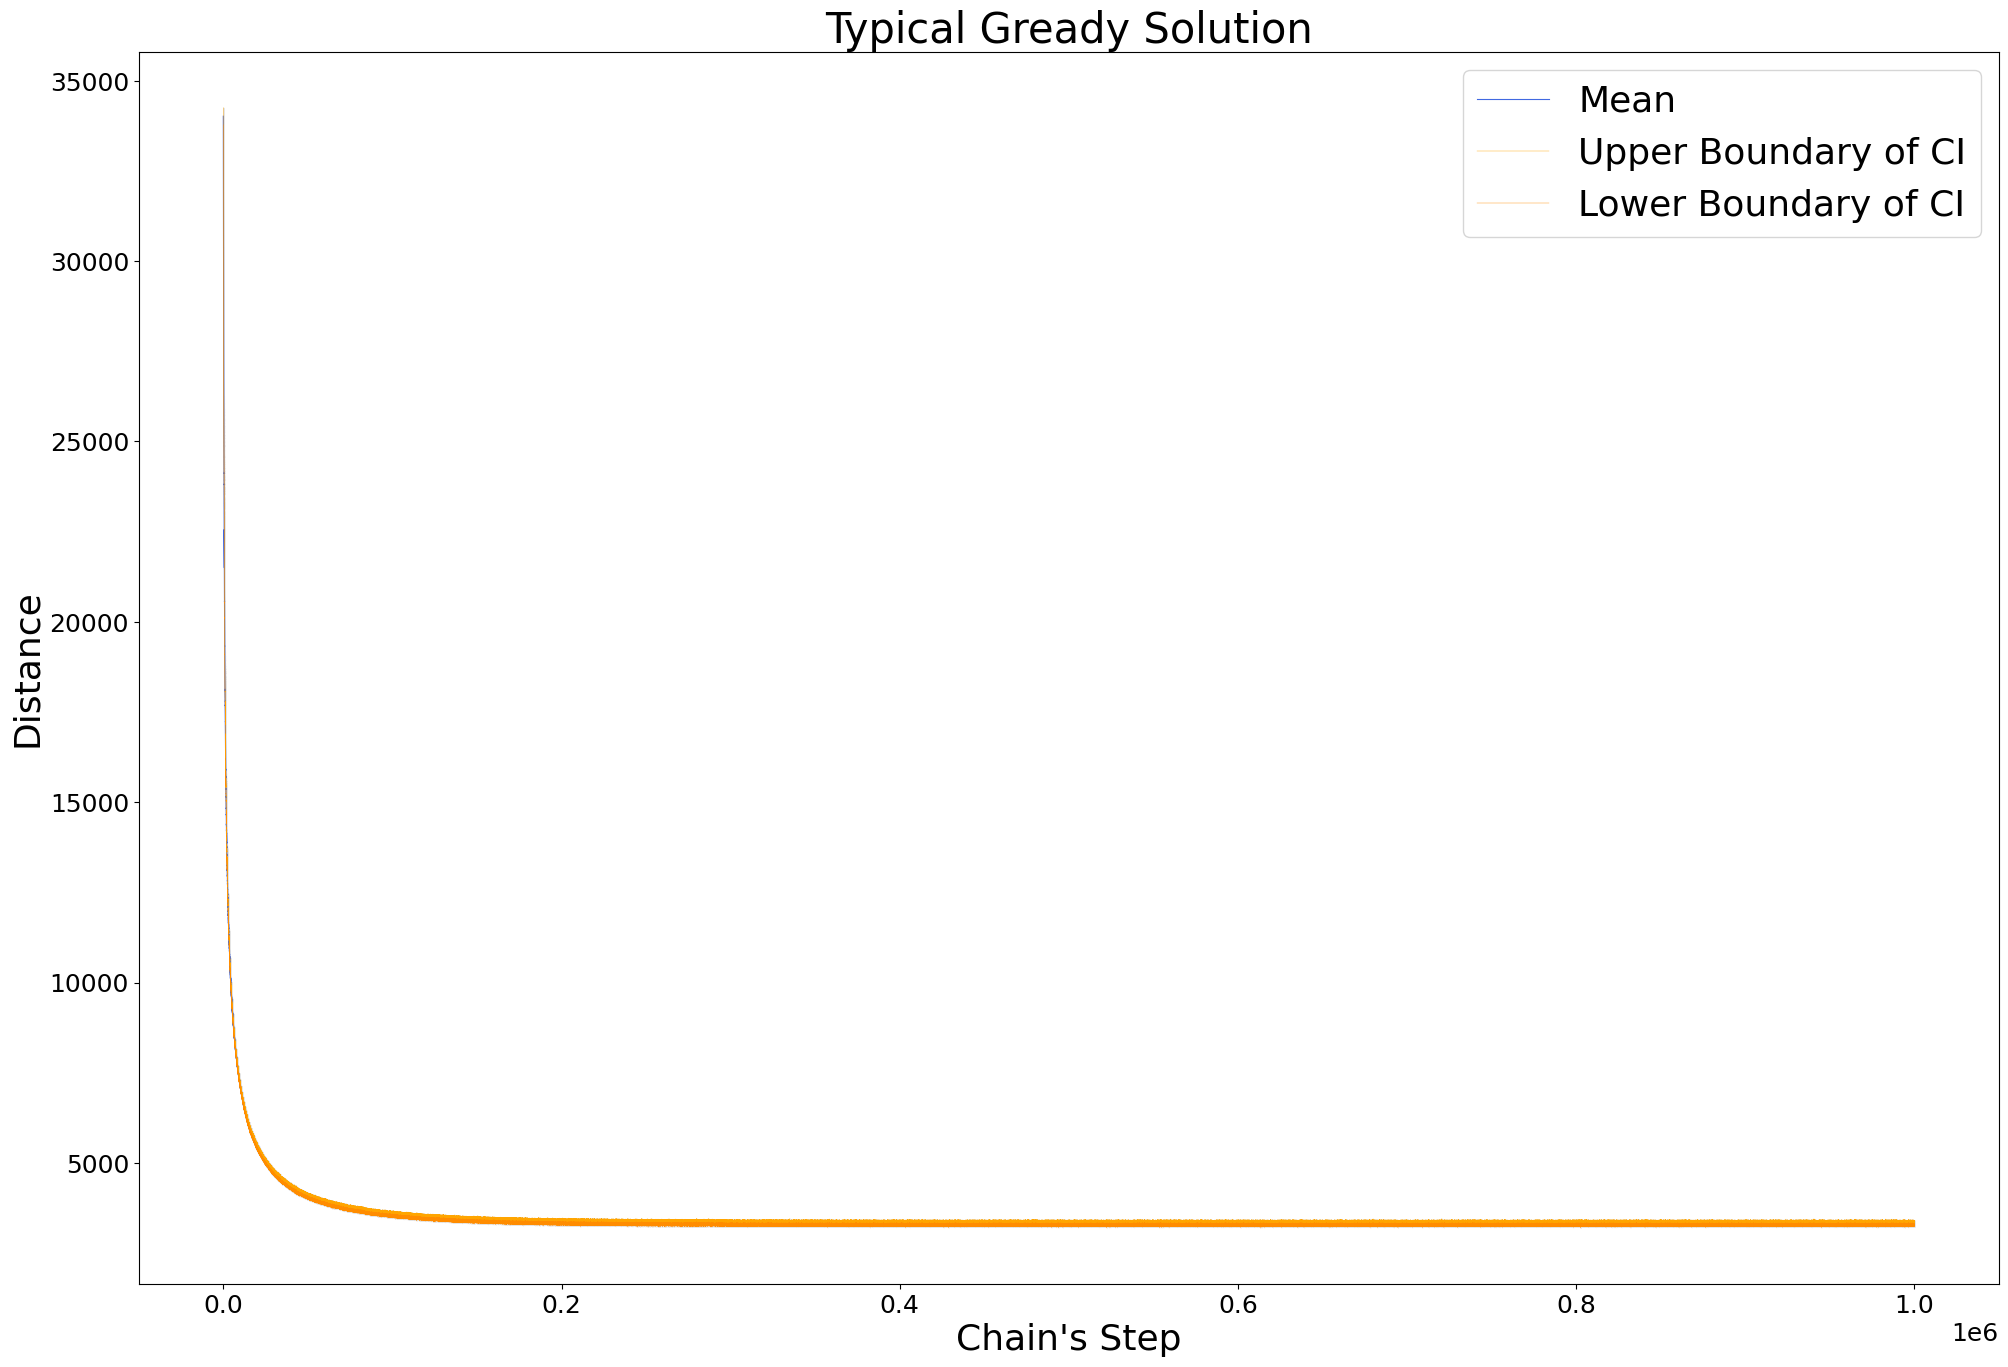

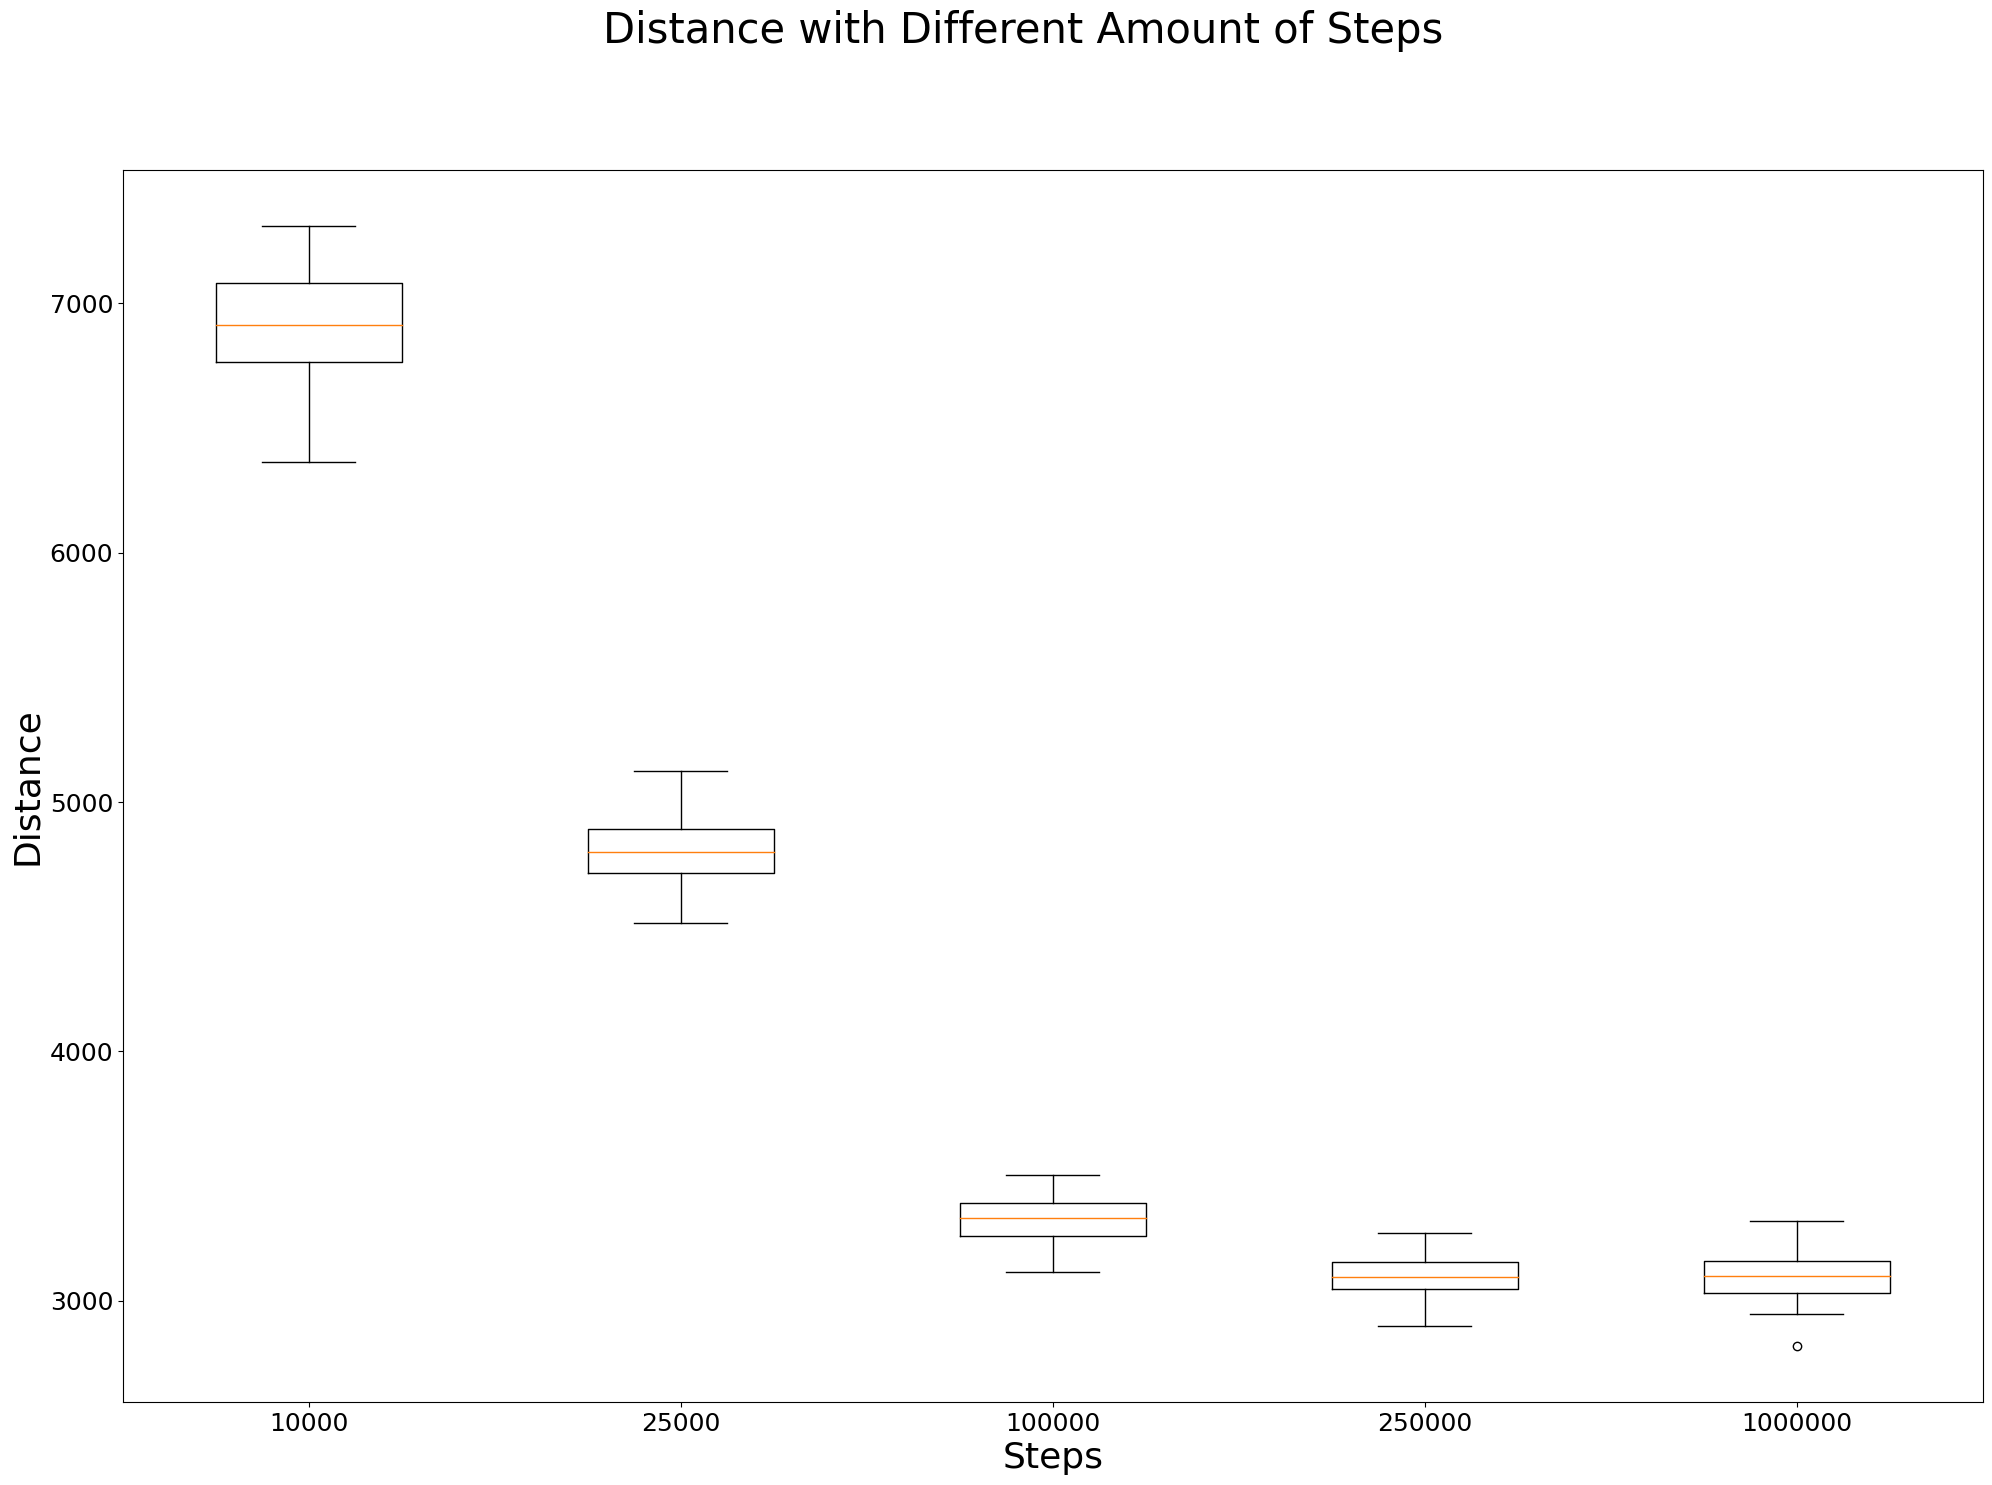

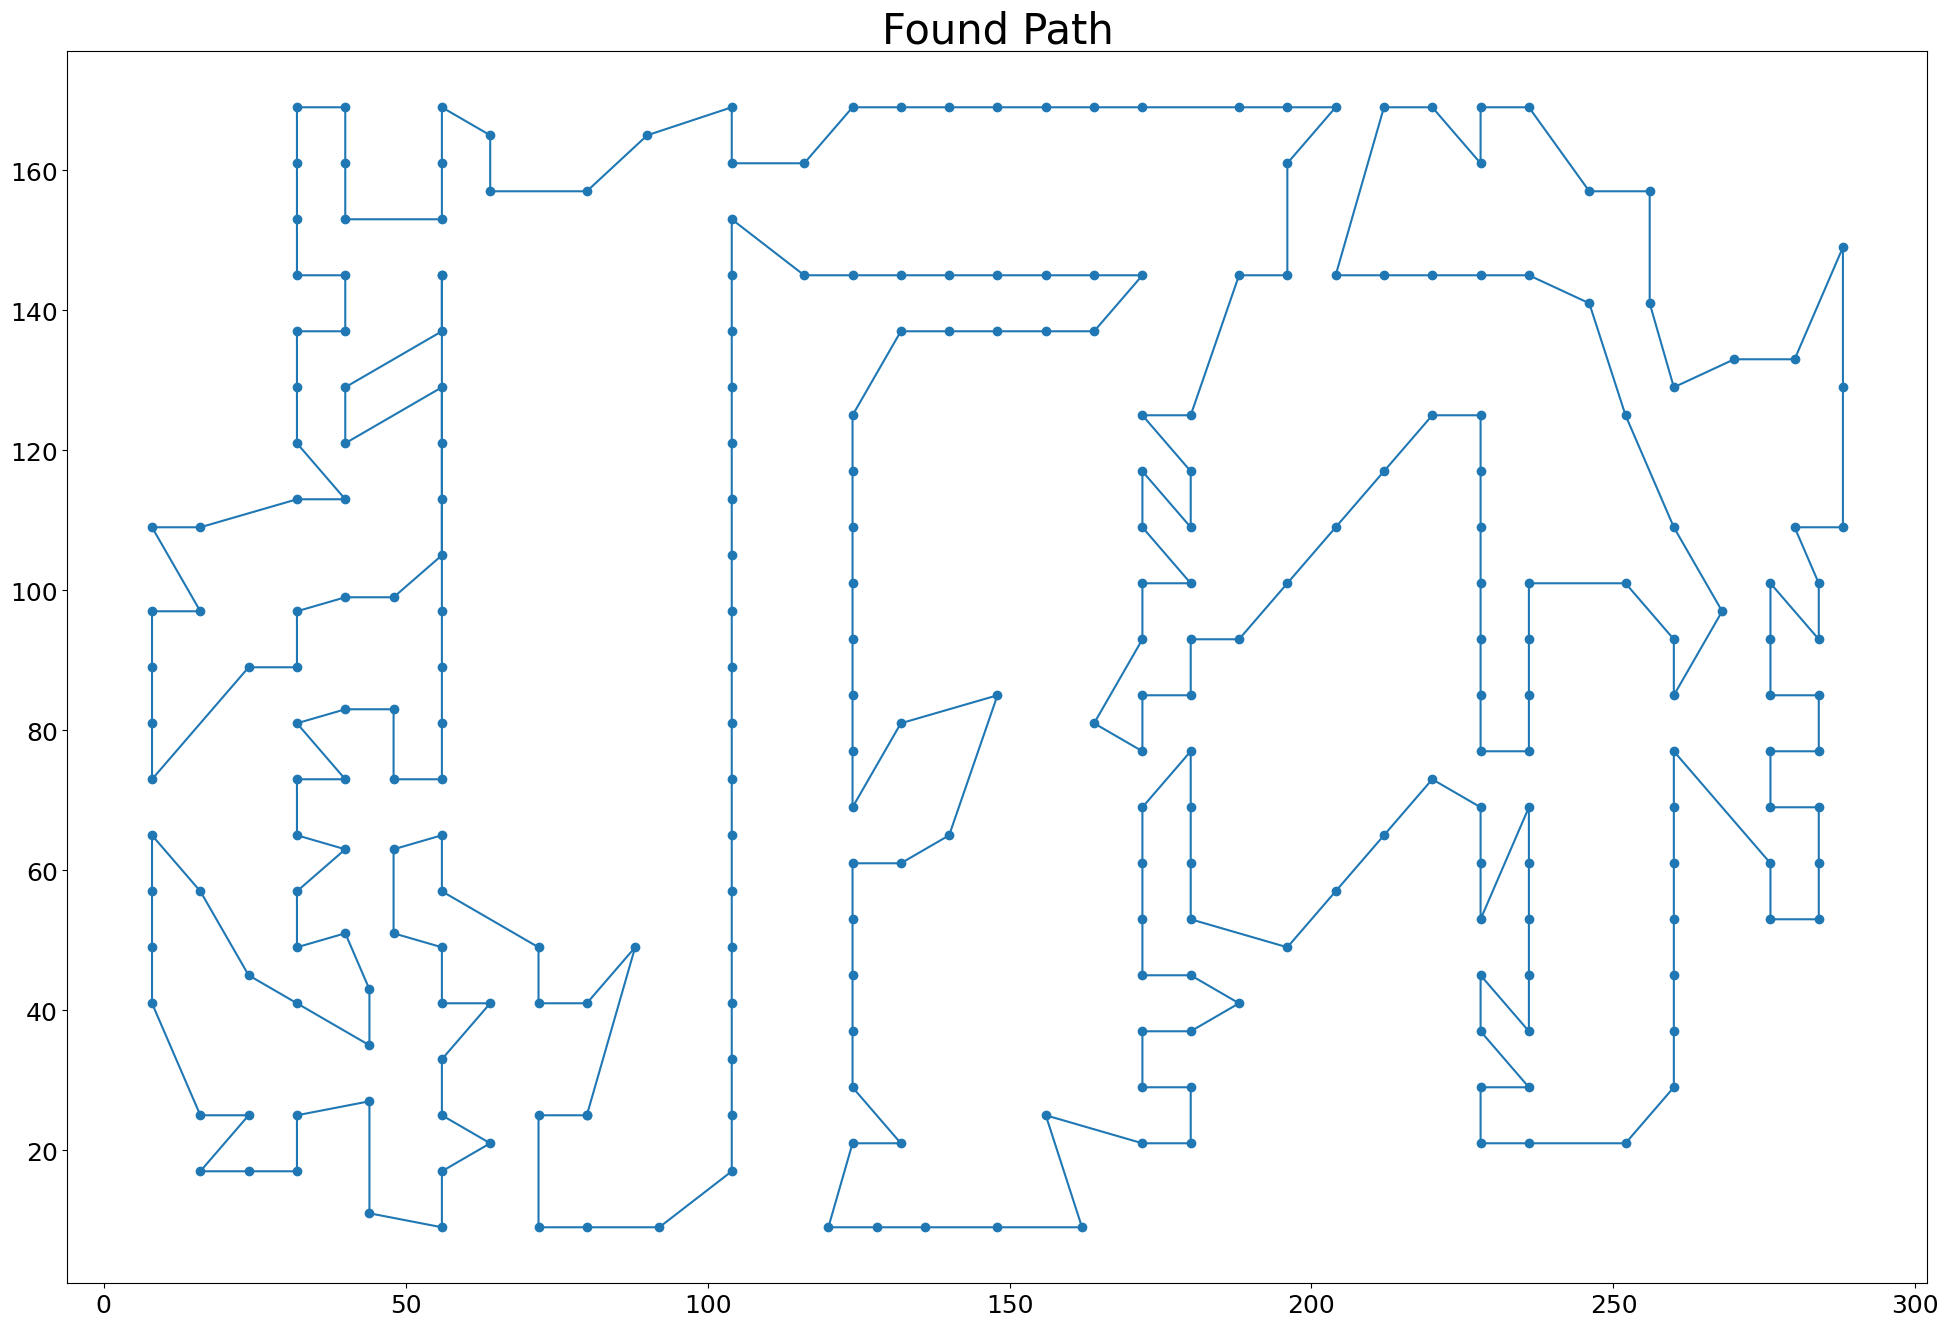

In [5]:
# Example of final path with Greedy Solution

step_max = [10_000, 25_000, 100_000, 250_000, 1_000_000]

best_solutions = []
the_best_solution = initial_path

# Generating Solutions
for steps_amount in step_max:

    history_chain_solutions = []
    history_best_solutions = []
    for i in tqdm(range(CI_SAMPLE_SIZE), desc ="Progress of running samples for CI"):
        best_sol, all_sol = greedy_solution("k-opt", 2, generate_initial_random_path(cities), steps_amount, False)
        if best_sol.eval_distance() < the_best_solution.eval_distance():
            the_best_solution = best_sol
        history_best_solutions.append(best_sol.eval_distance())
        history_chain_solutions.append(all_sol)

    # For visualization we need to Transpose results to find confidence intervals on each step
    history_chain_solutions_T = np.array(history_chain_solutions).T
    conf_means = []
    conf_stds = []
    for i in tqdm(range(len(history_chain_solutions_T)), desc ="Generating Visualization of Paths"):
        mean, std = confidence_interval(history_chain_solutions_T[i], 0.95, False)
        conf_means.append(mean)
        conf_stds.append(std)

    print("Typical Gready Solution with ", steps_amount, " Amount of Steps")
    print("Best found paths lengths: ", confidence_interval(history_best_solutions, 0.95, False))
    print()
    visualize_conf_interval(conf_means, conf_stds, "Typical Gready Solution", "Chain's Step", "Distance")
    best_solutions.append(history_best_solutions)

box_plot(best_solutions, "Distance with Different Amount of Steps", "Steps", step_max, "Distance")
the_best_solution.visualize()


# Comparing Different TSP Algorithms

In [6]:
step_max = 100_000

best_solutions_random_2 = []
best_solutions_random_3 = []

best_solutions_insert_2 = []
best_solutions_insert_3 = []

best_solutions_2opt = []
best_solutions_3opt = []

for i in tqdm(range(CI_SAMPLE_SIZE), desc ="Progress of running different TSP algorithms"):
    # Creating Random Path
    initial_path = generate_initial_random_path(cities)

    # Getting Solutions
    best_path_random, all_sol_random = greedy_solution("random", 2, initial_path, step_max, False)
    best_solutions_random_2.append(best_path_random.eval_distance())
    best_path_random, all_sol_random = greedy_solution("random", 3, initial_path, step_max, False)
    best_solutions_random_3.append(best_path_random.eval_distance())

    best_path_insert, all_sol_insert = greedy_solution("insert", 2, initial_path, step_max, False)
    best_solutions_insert_2.append(best_path_insert.eval_distance())
    best_path_insert, all_sol_insert = greedy_solution("insert", 3, initial_path, step_max, False)
    best_solutions_insert_3.append(best_path_insert.eval_distance())

    best_path_2opt, all_sol_2opt = greedy_solution("k-opt", 2, initial_path, step_max, False)
    best_solutions_2opt.append(best_path_2opt.eval_distance())
    best_path_3opt, all_sol_3opt = greedy_solution("k-opt", 3, initial_path, step_max, False)
    best_solutions_3opt.append(best_path_3opt.eval_distance())

# Calculating Confidence Intervals
print("Comparing Different TSP Algorithms:")
print("best_solutions_random_2: ", confidence_interval(best_solutions_random_2, 0.95, False))
print("best_solutions_random_3: ", confidence_interval(best_solutions_random_3, 0.95, False))
print("best_solutions_insert_2: ", confidence_interval(best_solutions_insert_2, 0.95, False))
print("best_solutions_insert_3: ", confidence_interval(best_solutions_insert_3, 0.95, False))
print("best_solutions_2opt: ", confidence_interval(best_solutions_2opt, 0.95, False))
print("best_solutions_3opt: ", confidence_interval(best_solutions_3opt, 0.95, False))

Progress of running different TSP algorithms: 100%|██████████| 50/50 [9:39:44<00:00, 695.68s/it]  

Comparing Different TSP Algorithms:
best_solutions_random_2:  (9349.136073493743, 111.27168660331012)
best_solutions_random_3:  (11508.642564984795, 101.28228849866395)
best_solutions_insert_2:  (6998.902754192796, 109.55007620635322)
best_solutions_insert_3:  (9663.413413350592, 129.5133899488684)
best_solutions_2opt:  (3307.8287121487897, 26.032291215197947)
best_solutions_3opt:  (5565.960175574854, 44.70760396796327)
